# PREREQUISITE: Installation Steps
add steps here:

In [1]:
SKIP_INSTALL = True

In [1]:
from IPython.core.magic import register_cell_magic

@register_cell_magic
def skip(line, cell):
  if globals().get('SKIP_INSTALL', False):
    print("Skipping installation cell.")
  else:
    get_ipython().run_cell(cell)

In [3]:
# SKIP_INSTALL = False

In [ ]:
%%skip

import contextlib
import io
import time
import sys
import subprocess
import re
import os

def capture_output():
  return contextlib.redirect_stdout(io.StringIO())

print("Downloads take ~5 minutes but are required for version compatiability!")
time.sleep(1)

with capture_output():
  package_versions = {
    "numpy": "1.26.4",
    "torch": "2.2.2",
    "transformers": "4.50.3",
    "datasets": "2.18.0",
    "scipy": "1.12.0",
    "pandas": "2.1.4",
    "scikit-learn": "1.4.0",
    "gensim": "4.3.2",
    "evaluate": "0.4.1"
  }

  # get cuda version
  cuda_version_str = "N/A"
  cuda_major_minor = None
  nvcc_output = subprocess.check_output(['nvcc', '--version']).decode('utf-8')
  match_obj = re.search(r'release (\d+\.\d+)', nvcc_output)
  if match_obj:
    cuda_version_str = match_obj.group(1)
    cuda_major_minor = "".join(cuda_version_str.split('.'))

  # pytorch installation
  pytorch_version = package_versions["torch"]
  pytorch_cuda_suffix = "cu118"
  if cuda_major_minor and int(cuda_major_minor) >= 121:
    pytorch_cuda_suffix = "cu121"

  torchvision_version = "0.17.2"
  torchaudio_version = "2.2.2"
  pytorch_index_url = f"https://download.pytorch.org/whl/{pytorch_cuda_suffix}"

  pytorch_install_command = (
    f"pip3 install "
    f"torch=={pytorch_version}+{pytorch_cuda_suffix} "
    f"torchvision=={torchvision_version}+{pytorch_cuda_suffix} "
    f"torchaudio=={torchaudio_version}+{pytorch_cuda_suffix} "
    f"--index-url {pytorch_index_url} --upgrade --no-cache-dir"
  )
  get_ipython().system(pytorch_install_command)

  # install specified packages
  get_ipython().system('pip3 uninstall transformers -y')
  packages_to_install = [
    f"{pkg}=={ver}" for pkg, ver in package_versions.items() if pkg != "torch"
  ]
  other_packages_install_command = (
    "pip3 install --upgrade --no-cache-dir " + " ".join(packages_to_install)
  )

  get_ipython().system(other_packages_install_command)
  get_ipython().system(
    'pip install "huggingface_hub[hf_xet]" --upgrade --no-cache-dir'
  )

# restart environment
print("Package installation completed successfully!")
os._exit(0)

Downloads take ~5 minutes but are required for version compatiability!


In [5]:
# basic imports
import gensim
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

import importlib.metadata
import sys
version = importlib.metadata.version("torch")
print(version)

2.2.2+cu121


# Part 1. Word Embeddings and N-gram

In [6]:
import nltk
from nltk.corpus import twitter_samples, stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

import gensim.downloader as api
from gensim.models import FastText, Word2Vec
from gensim.test.utils import datapath

from sklearn.metrics.pairwise import cosine_similarity

import re
import string

## Part 1. (1a-1b) You will examine two-word embeddings. You are given the following words:

Dog, Bark, Tree, Bank, River, Money.

Do the following:
- Use Glove-twitter-50D word2vec and compute nxn matrices using cosine similarities for the given words.
- Use FastText and compute nxn matrices using cosine similarities for the given words.

In [7]:
# download glove-twitter-50 model
nltk.download("twitter_samples")
nltk.download('stopwords')
if "glove" not in globals():
  glove = api.load("glove-twitter-50")

print("downloads completed!")

[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Unzipping corpora/twitter_samples.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


[==================================================] 100.0% 199.5/199.5MB downloaded
downloads completed!


In [8]:
# data preprocessing
# https://www.kaggle.com/code/piyushagni5/sentiment-analysis-on-twitter-dataset-nlp
def process_tweet(tweet):
  stemmer = PorterStemmer()
  stopwords_english = stopwords.words('english')

  tweet = re.sub(r'\$\w*', '', tweet)
  tweet = re.sub(r'^RT[\s]+', '', tweet)
  tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
  tweet = re.sub(r'#', '', tweet)

  tokenizer = TweetTokenizer(
    preserve_case=False, strip_handles=True, reduce_len=True
  )
  tweet_tokens = tokenizer.tokenize(tweet)

  tweets_clean = []
  for word in tweet_tokens:
    if (word not in stopwords_english and word not in string.punctuation):
      stem_word = stemmer.stem(word)
      tweets_clean.append(stem_word)

  return tweets_clean

negative_tweets = twitter_samples.strings("negative_tweets.json")
positive_tweets = twitter_samples.strings("positive_tweets.json")
common_texts = [
  process_tweet(tweet)
  for tweet_list in [negative_tweets, positive_tweets]
  for tweet in tweet_list
]
print(f"Number of tweets: {len(common_texts)}")

Number of tweets: 10000


In [9]:
# train the Word2Vec and FastText models
# NOTE: our GloVe w2v model is already loaded
if "w2v" not in globals():
  w2v = Word2Vec(sentences=common_texts, vector_size=50, window=5, min_count=1)
if "ft" not in globals():
  ft = FastText(
    vector_size=50, window=5, min_count=1, sentences=common_texts, epochs=10
  )
print("done training models!")

done training models!


In [10]:
# create similarity matrices of the words for each model
def create_similarity_matrix(model, words, glove_model=False):
  if glove_model:
    common_text_words = set([word for text in common_texts for word in text])
    glove_words = [
      word.lower() for word in glove.key_to_index
      if word.lower() in common_text_words
    ]
    words_in_model = [w for w in words if w in glove_words]
  else:
    words_in_model = [w for w in words if w in model.wv]

  word_vectors = np.array(
    [
      model.get_vector(word) if glove_model else model.wv[word]
      for word in words_in_model
    ]
  )
  similarity_matrix = cosine_similarity(word_vectors)
  return similarity_matrix, words_in_model

words = ["dog", "bark", "tree", "bank", "river", "money"]
glove_matrix, words_in_glove = create_similarity_matrix(
  glove, words, glove_model=True
)
w2v_matrix, words_in_w2v = create_similarity_matrix(w2v, words)
ft_matrix, words_in_ft = create_similarity_matrix(ft, words)

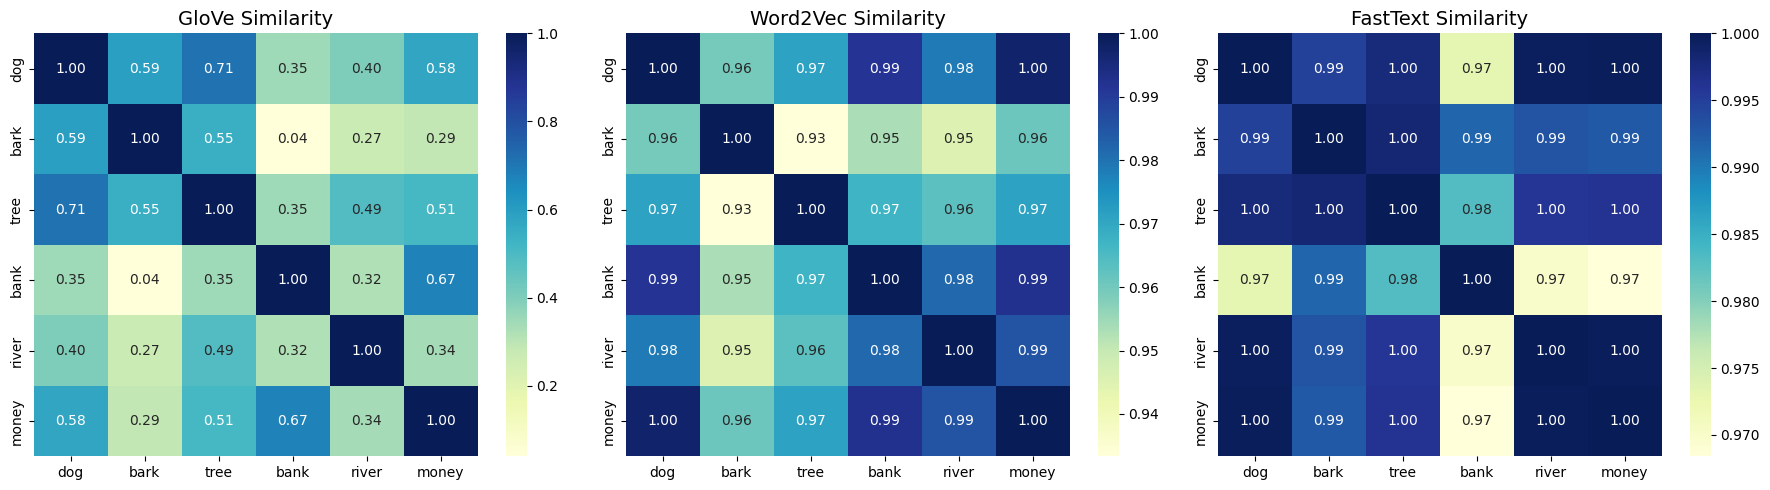

In [11]:
# plot the similarity matrices for each model
def plot_similarity_matrices(matrices, words_lists, titles):
  n = len(matrices)
  fig, axes = plt.subplots(1, n, figsize=(n * 6, 5))
  for i in range(n):
    sns.heatmap(
      matrices[i],
      annot=True,
      fmt=".2f",
      cmap="YlGnBu",
      xticklabels=words_lists[i],
      yticklabels=words_lists[i],
      ax=axes[i]
    )
    axes[i].set_title(titles[i], fontsize=14)

  plt.tight_layout()
  plt.show()

matrices = [glove_matrix, w2v_matrix, ft_matrix]
words_lists = [words_in_glove, words_in_w2v, words_in_ft]
titles = ["GloVe Similarity", "Word2Vec Similarity", "FastText Similarity"]
plot_similarity_matrices(matrices, words_lists, titles)

## Part 1. (1c) Which embedding captures better semantics? Justify your answer.<br>
**Answer:** Based on the similarity scores between the 6 words, the GloVe model is better at capturing the semantics, i.e the meaning, of the words. The FastText model is a close second. Since there is not a universal standard similarity score for these specific word pairs I am using my own understanding of the english language to evaluate.

Words with multiple meanings:
- Bark: Dog barking or tree bark
- Bank: River bank or a bank that manages money

Related pairs:
- Dog-Bark
- Tree-Bark
- Money-Bank
- River-Bank

Model Evaluation:
- **GloVe:** The similarity matrix shows clear differentiation between semantically distinct words. For example, the similarity between “bark” and “bank” is extremely low and the similarity between "money" and "bank" is relatively high.
- **Word2Vec:** Shows high similarity scores across most of the pairs and does not differentiate unrelated words. For example, the words "dog" and "tree" are unrelated but have an extremely high similarity score.
- **FastText:** Is able to capture semantic of words but at a more moderate extent than GloVe. This moderate scoring does not differentiate as clearly between related and unrelated pairs as GloVe does.

Based only on their 6-word similarity matrices, the GloVe model provides more realistic similarity scores and thus captures the semantic similarities between words better than the other models.

In [12]:
benchmark = "simlex999.txt"
result_glove = glove.evaluate_word_pairs(datapath(benchmark))
result_w2v = w2v.wv.evaluate_word_pairs(datapath(benchmark))
result_ft = ft.wv.evaluate_word_pairs(datapath(benchmark))

print(f"GloVe Spearman Measurements:")
print(f" - Coefficient: {result_glove[1][0]:.4f}")
print(f" - P-Value: {result_glove[1][1]:.4f}")

print(f"Word2Vec Spearman Measurements:")
print(f" - Coefficient: {result_w2v[1][0]:.4f}")
print(f" - P-Value: {result_w2v[1][1]:.4f}")

print(f"FastText Spearman Measurements:")
print(f" - Coefficient: {result_ft[1][0]:.4f}")
print(f" - P-Value: {result_ft[1][1]:.4f}")

GloVe Spearman Measurements:
 - Coefficient: 0.0975
 - P-Value: 0.0021
Word2Vec Spearman Measurements:
 - Coefficient: -0.0456
 - P-Value: 0.4022
FastText Spearman Measurements:
 - Coefficient: 0.0467
 - P-Value: 0.3912


## Part 1. (1c) Continued analysis...<br>
**Answer:** I wanted to see which model performed better on a larger set of words so I measured the Spearman Coefficients of each model on the 'simlex999' dataset. In our context, the Spearman Coefficient judges how well our model's predictions match a human's analysis of word pairs. A higher coefficient shows a better match. On the 'simlex999' dataset, the GloVe model achieves the highest Spearman coefficient and is the only model with a statistically significant p-value, indicating that it does the best at capturing overall semantic relationships across a broader range of word pairs.

## Part 1. (2a-2c) N-grams and Classification

Do the following:
- Split the data 70% training and 30% testing.
- Extract n-grams for n in [1, 4]. unigram, bigram, trigram, 4-grams.
- Build a logistic regression model using n-gram features.

In [13]:
import random
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer
from nltk.util import ngrams

In [14]:
# split the data into 70% training and 30% testing
seed = 2025
random.seed(seed)
labels = np.array([0] * len(negative_tweets) + [1] * len(positive_tweets))
train_texts, test_texts, train_labels, test_labels = train_test_split(
  common_texts, labels, test_size=0.3, random_state=seed
)

In [15]:
# extract n-grams for n in [1, 4]. unigram, bigram, trigram, 4grams.
def get_text_ngrams(text, n_range):
  text_ngrams = []
  for i in n_range:
    text_string = ["_".join(gram) for gram in list(ngrams(text, i))]
    text_ngrams.extend(text_string)

  return " ".join(text_ngrams)

train_features = [get_text_ngrams(text, range(1, 5)) for text in train_texts]
test_features = [get_text_ngrams(text, range(1, 5)) for text in test_texts]

In [16]:
# logistic regression model
def train_and_predict_model(
  train_features, test_features, train_labels, test_labels
):
  vectorizer = CountVectorizer()
  X_train = vectorizer.fit_transform(train_features)
  X_test = vectorizer.transform(test_features)

  model = LogisticRegression(max_iter=1000)
  model.fit(X_train, train_labels)

  y_pred = model.predict(X_test)
  accuracy = accuracy_score(test_labels, y_pred)
  report = classification_report(test_labels, y_pred)

  return accuracy, report

accuracy, report = train_and_predict_model(
  train_features, test_features, train_labels, test_labels
)
print(f'Accuracy: {accuracy:.4f}')
print(report)

Accuracy: 0.7350
              precision    recall  f1-score   support

           0       0.71      0.79      0.75      1482
           1       0.77      0.68      0.72      1518

    accuracy                           0.73      3000
   macro avg       0.74      0.74      0.73      3000
weighted avg       0.74      0.73      0.73      3000



## Part 1. (2c) Evaluate your logistic regression model's performance.<br>
**Answer:** My logistic regression model has an accuracy of ~73.5% with similar performance for predicting positive and negative sentiment in tweets. My model has better precision (fewer false positives) for positive sentiment tweets and better recall (fewer false negatives) for negative sentiment tweets. These results show that even a simple logistic regression model can predict sentiment in tweets with decent accuracy when trained with n-grams.

## Part 1. (2d) Plotting model accuracy vs n

In [17]:
# compare cumulative vs stand alone ngram accuracies
def get_accuracy_scores(train_texts, test_tests, n_range, cumulative):
  accuracy_scores = []
  for i in n_range:
    r = range(i+1) if cumulative else range(i, i+1)
    train_features = [get_text_ngrams(text, r) for text in train_texts]
    test_features = [get_text_ngrams(text, r) for text in test_texts]

    accuracy, report = train_and_predict_model(
      train_features, test_features, train_labels, test_labels
    )
    print(
      f"{'CUMULATIVE' if cumulative else 'SINGLE'}, n={i}, acc={accuracy:.4f}"
    )
    accuracy_scores.append(accuracy)

  return accuracy_scores

n_range = range(1, 10)
cumulative_accs = get_accuracy_scores(train_texts, test_texts, n_range, True)
single_accs = get_accuracy_scores(train_texts, test_texts, n_range, False)

CUMULATIVE, n=1, acc=0.7237
CUMULATIVE, n=2, acc=0.7370
CUMULATIVE, n=3, acc=0.7373
CUMULATIVE, n=4, acc=0.7350
CUMULATIVE, n=5, acc=0.7333
CUMULATIVE, n=6, acc=0.7320
CUMULATIVE, n=7, acc=0.7300
CUMULATIVE, n=8, acc=0.7283
CUMULATIVE, n=9, acc=0.7300
SINGLE, n=1, acc=0.7237
SINGLE, n=2, acc=0.6657
SINGLE, n=3, acc=0.5940
SINGLE, n=4, acc=0.5650
SINGLE, n=5, acc=0.5523
SINGLE, n=6, acc=0.5430
SINGLE, n=7, acc=0.5317
SINGLE, n=8, acc=0.5223
SINGLE, n=9, acc=0.5157


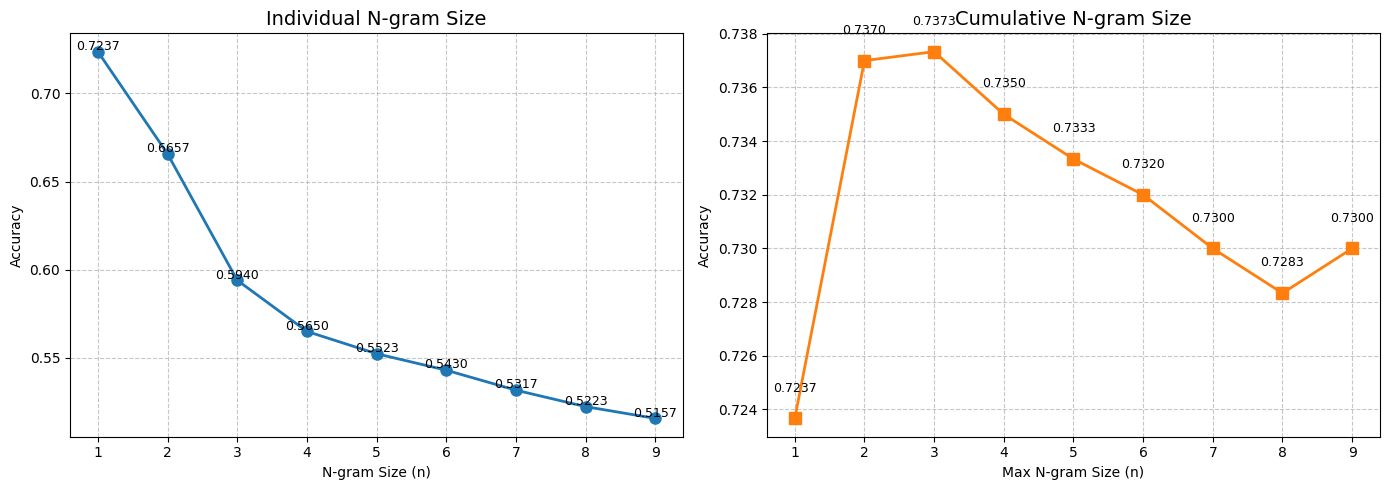

In [18]:
def create_accuracy_plot(ax, n_range, accuracies, title, cumulative=False):
  marker = 's' if cumulative else 'o'
  color = '#ff7f0e' if cumulative else '#1f77b4'
  ax.plot(
    n_range,
    accuracies,
    marker=marker,
    linestyle='-',
    color=color,
    linewidth=2,
    markersize=8
  )
  ax.set_xlabel('Max N-gram Size (n)' if cumulative else 'N-gram Size (n)')
  ax.set_ylabel('Accuracy')
  ax.set_title(title, fontsize=14)
  ax.grid(True, linestyle='--', alpha=0.7)
  ax.set_xticks(n_range)

  for i, acc in enumerate(accuracies):
    ax.text(n_range[i], acc + 0.001, f'{acc:.4f}', ha='center', fontsize=9)

def plot_ngram_comparison(n_range, single_accs, cumulative_accs):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
  create_accuracy_plot(
    ax1, n_range, single_accs, 'Individual N-gram Size'
  )
  create_accuracy_plot(
    ax2, n_range, cumulative_accs, 'Cumulative N-gram Size', True
  )

  plt.tight_layout()
  plt.show()

plot_ngram_comparison(n_range, single_accs, cumulative_accs)

## Part 1. (2d) How does the value of n in n-gram affect the model's performance?
Explain your answer. You can draw a plot with n-gram and the model's performance.<br>
**Answer:** The size of n and wether or not the n-grams are cumulative both have an impact on the model's accuracy.

In terms of individual contributions to the model's accuracy, the unigrams have the most impact and provide the highest accuracy. This makes sense because individual words provide the majority of the sentiment in sentences. For cumulative n-grams, a maximum size of 3 provides the highest accuracy. After this point increasing the size of n leads to decreasing accuracy. Including up to trigrams provide the best accuracy because sentiment is often conveyed in 1-3 words in the english language. For example, two words are a requirement to convey the sentiment when saying something is 'not good'.

Overall unigrams, bigrams, and trigrams make up most of the contributions to the model's accuracy. Any additional increases to n lead to diminishing accuracy because a majority of the sentiment is captured in just 1-3 word n-grams.

# Part 2. RNN and Machine Translation
You will be training a Seq2seq model using RNN. Your input will be a text and the output will be a summary of the text.

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

import nltk
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu

from transformers import AutoTokenizer, DataCollatorForSeq2Seq
from transformers import AutoModelForSeq2SeqLM
from transformers import Seq2SeqTrainingArguments
from transformers import Seq2SeqTrainer
from transformers import BartTokenizer, BartForConditionalGeneration

from datasets import load_dataset
from sklearn.model_selection import train_test_split

## Part 2. (1) Load the California State bill subset of the BillSum dataset from HuggingFace.
Do the following:
- Load the test split as your entire dataset for this task.
- Split the dataset into a train and test set with the train test split method.

In [29]:
# download the data
nltk.download('punkt')
nltk.download('punkt_tab')

print("downloads completed!")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


downloads completed!


In [21]:
# load and format the data
# https://huggingface.co/docs/transformers/main/en/tasks/summarization
billsum = load_dataset("billsum", split="ca_test")
billsum = billsum.train_test_split(test_size=0.2)
# checkpoint = "google-t5/t5-small"
checkpoint = "facebook/bart-base"

model_name = "facebook/bart-base"
tokenizer = BartTokenizer.from_pretrained(model_name)


# tokenizer = AutoTokenizer.from_pretrained(checkpoint)
# def get_preprocess_function(input_max_length=1024, summary_max_length=128):
#   def preprocess_function(examples):
#     inputs = ["summarize: " + doc for doc in examples["text"]]
#     model_inputs = tokenizer(
#       inputs, max_length=input_max_length, truncation=True
#     )
#     labels = tokenizer(
#       text_target=examples["summary"],
#       max_length=summary_max_length,
#       truncation=True
#     )
#     model_inputs["labels"] = labels["input_ids"]
#     return model_inputs
#   return preprocess_function

# tokenized_billsum = billsum.map(get_preprocess_function(), batched=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/18949 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3269 [00:00<?, ? examples/s]

Generating ca_test split:   0%|          | 0/1237 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/989 [00:00<?, ? examples/s]

Map:   0%|          | 0/248 [00:00<?, ? examples/s]

In [22]:
def compute_metrics(eval_pred):
  predictions, labels = eval_pred
  decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
  labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
  decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

  # Tokenize predictions and references for BLEU calculation
  tokenized_preds = [nltk.word_tokenize(pred.lower()) for pred in decoded_preds]
  tokenized_labels = [[nltk.word_tokenize(label.lower())] for label in decoded_labels]  # List of lists of references

  # Compute corpus BLEU score
  bleu_score = corpus_bleu(tokenized_labels, tokenized_preds)

  # Compute BLEU-1, BLEU-2, BLEU-3, and BLEU-4 scores
  weights_1 = (1.0, 0.0, 0.0, 0.0)
  weights_2 = (0.5, 0.5, 0.0, 0.0)
  weights_3 = (0.33, 0.33, 0.33, 0.0)
  weights_4 = (0.25, 0.25, 0.25, 0.25)

  bleu_1 = corpus_bleu(tokenized_labels, tokenized_preds, weights=weights_1)
  bleu_2 = corpus_bleu(tokenized_labels, tokenized_preds, weights=weights_2)
  bleu_3 = corpus_bleu(tokenized_labels, tokenized_preds, weights=weights_3)
  bleu_4 = corpus_bleu(tokenized_labels, tokenized_preds, weights=weights_4)

  # Add generation length information
  prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
  avg_gen_len = np.mean(prediction_lens)

  result = {
      "bleu": bleu_score,
      "bleu_1": bleu_1,
      "bleu_2": bleu_2,
      "bleu_3": bleu_3,
      "bleu_4": bleu_4,
      "gen_len": avg_gen_len
  }

  return {k: round(v, 4) for k, v in result.items()}

In [32]:
# Force CUDA to be visible and clear GPU memory
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
torch.cuda.empty_cache()

# Check GPU availability
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

# Set environment variables
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["WANDB_DISABLED"] = "true"

# Print dataset information
print(tokenized_billsum)

# Create data collator
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=checkpoint)

# Load pre-trained model with float32 precision
model = AutoModelForSeq2SeqLM.from_pretrained(
    checkpoint,
    low_cpu_mem_usage=True,
    torch_dtype=torch.float32,
    device_map="auto"
)

# Verify model device
print(f"Model device: {next(model.parameters()).device}")

# Define a safe compute_metrics function that handles potential errors
def safe_compute_metrics(eval_preds):
    try:
        preds, labels = eval_preds
        if isinstance(preds, tuple):
            preds = preds[0]

        # Clip extremely large token IDs to prevent overflow
        max_token_id = tokenizer.vocab_size - 1
        preds = np.clip(preds, 0, max_token_id)

        # Safely decode generated summaries
        decoded_preds = []
        for pred_seq in preds:
            try:
                # Filter out any token IDs that might cause issues
                safe_pred_seq = [tid for tid in pred_seq if 0 <= tid <= max_token_id]
                decoded_pred = tokenizer.decode(safe_pred_seq, skip_special_tokens=True)
                decoded_preds.append(decoded_pred)
            except Exception as e:
                print(f"Error decoding prediction: {e}")
                decoded_preds.append("")

        # Safely decode reference summaries
        decoded_labels = []
        labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
        for label_seq in labels:
            try:
                # Filter out any token IDs that might cause issues
                safe_label_seq = [tid for tid in label_seq if 0 <= tid <= max_token_id]
                decoded_label = tokenizer.decode(safe_label_seq, skip_special_tokens=True)
                decoded_labels.append(decoded_label)
            except Exception as e:
                print(f"Error decoding label: {e}")
                decoded_labels.append("")

        # Calculate metrics using your original compute_metrics function
        # This assumes your original function works with decoded texts
        return compute_metrics((decoded_preds, decoded_labels))

    except Exception as e:
        print(f"Error in compute_metrics: {e}")
        # Return some default metrics to prevent training failure
        return {"bleu": 0.0, "gen_len": 0.0}

# Set up training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="my_awesome_billsum_model",
    eval_strategy="steps",
    eval_steps=100,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    weight_decay=0.01,
    save_total_limit=1,
    num_train_epochs=4,
    predict_with_generate=True,
    fp16=False,
    bf16=False,
    push_to_hub=False,
    report_to=["none"],
    run_name=None,
    logging_steps=50,
    save_strategy="steps",
    save_steps=100,
    optim="adamw_torch",
    max_grad_norm=1.0,
    generation_max_length=128,
    generation_num_beams=4,
)

# Create trainer with our safe metrics function
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_billsum["train"],
    eval_dataset=tokenized_billsum["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=safe_compute_metrics,
)

trainer.train()

results = trainer.evaluate(resume_from_checkpoint=True)
print("Final evaluation results:")
print(results)

PyTorch version: 2.2.2+cu121
CUDA available: True
DatasetDict({
    train: Dataset({
        features: ['text', 'summary', 'title', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 989
    })
    test: Dataset({
        features: ['text', 'summary', 'title', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 248
    })
})
Model device: cuda:0


<ipython-input-32-29d1c86ba169>:103: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Step,Training Loss,Validation Loss,Bleu,Gen Len
100,2.314500,2.082271,0.000000,0.000000


Error in compute_metrics: argument 'ids': Can't extract `str` to `Vec`


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3353: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Step,Training Loss,Validation Loss,Bleu,Gen Len
100,2.314500,2.082271,0.000000,0.000000
200,2.100100,2.018750,0.000000,0.000000


Error in compute_metrics: argument 'ids': Can't extract `str` to `Vec`


Error in compute_metrics: argument 'ids': Can't extract `str` to `Vec`
Final evaluation results:
{'eval_loss': 2.0108625888824463, 'eval_bleu': 0.0, 'eval_gen_len': 0.0, 'eval_runtime': 112.5303, 'eval_samples_per_second': 2.204, 'eval_steps_per_second': 0.275, 'epoch': 4.0}
